# **Daily Gold Price Forecasting**

*By: Zhi Shen*

*Last updated: 27/05/2022*

---

**Summary:**

Forcasted the daily high price of gold within 95% confidence by training a Hybrid model consisting of a ElasticNet Regressor and a RandomForestRegressor.

**Table of contents:**

1. Set Up
2. Problem Formulation
3. Data Visualization
4. Modeling and Evaluation

# **Set Up**

---

The following code block will import all the necessary packages that are used.

In [1]:
import numpy as np # numeric processing 
import pandas as pd # data handling and processing

import matplotlib.pyplot as plt # low level API for data visualization
import seaborn as sns # high level API for data visualization

from scipy.signal import periodogram # creation of data visualization
from statsmodels.graphics.tsaplots import plot_pacf # creation of data visualization
from statsmodels.graphics.tsaplots import plot_acf # creation of data visualization

from statsmodels.tsa.deterministic import DeterministicProcess # creation of time dummy variable
from statsmodels.tsa.deterministic import CalendarFourier # creation of seasonal variables

from sklearn.linear_model import ElasticNet # model 1 in hybrid model
from sklearn.ensemble import RandomForestRegressor # model 2 in hybrid model 

from sklearn.metrics import mean_squared_error # error metric
from sklearn.metrics import mean_absolute_error # final evaluation

# **Problem Formulation**

---

## Dataset Introduction

Dataset from Kaggle: *'Daily Gold Price (2015-2021) Time Series'* by Nisarg Chodavadiya. 

Source: https://www.kaggle.com/datasets/nisargchodavadiya/daily-gold-price-20152021-time-series (requires login to download)

This dataset contains information about the price of gold on a daily basis, specifically, the opening, closing, highest and lowest price of each day. In addition, the volume of gold traded as well as the percentage change were also recorded. Although the name seems to imply that only data from 2015 to 2021 is provided, the time series contained within ranges from 01/01/2014 to 29/12/2021.

The dataset has already been cleaned and preprocessed, therefore there will be no missing values that need to be filled in or duplicate entries which need to be removed.

In [2]:
# load in the dataset
df = pd.read_csv('../input/daily-gold-price-20152021-time-series/Gold Price.csv', index_col = 'Date', parse_dates = True, infer_datetime_format = True)

In [3]:
# basic EDA
print("Basic information".center(100, '-'))
df.info()
print("NULL/Duplicate entries".center(100, '-'))
print(f"Number of duplicate entries: {df.duplicated().sum()}")
print(f"Number of null entries: \n{df.isna().sum()}")

-----------------------------------------Basic information------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2072 entries, 2014-01-01 to 2021-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2072 non-null   int64  
 1   Open    2072 non-null   int64  
 2   High    2072 non-null   int64  
 3   Low     2072 non-null   int64  
 4   Volume  2072 non-null   int64  
 5   Chg%    2072 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 113.3 KB
---------------------------------------NULL/Duplicate entries---------------------------------------
Number of duplicate entries: 0
Number of null entries: 
Price     0
Open      0
High      0
Low       0
Volume    0
Chg%      0
dtype: int64


## Problem Statement

Naturally, the problem tackled within this notebook is 

```
> What is the highest price of gold on a given day?
```

For the purposes of this notebook, I will assume that the model makes the prediction right when the opening price for that day is released.

**Approach**

There are 4 components to a time series:

1. Trend
2. Seasonality
3. Cyclical fluctuations
4. Irregular variations

During the Data Visualization stage, I will try to get a better understanding of whether these 4 components are present within the data as it will aid in the creation of models to predict the price of gold.

To make our predictions, a Hybrid Model will be used. The details of the Hybrid Model are found here: https://www.kaggle.com/code/ryanholbrook/hybrid-models. However, some minor changes have been made to the model.

A 70, 20, 10 split will be used for the train, validation and test datasets and mean squared error will be used to evaluate the model.

```
The training data will be 17/06/2021 to 01/11/2021.
The validation data will be from 02/11/2021 to 09/12/2021.
The test data will be from 10/12/2021 to 29/12/2021.'
```

In [4]:
# creation of train, validate, test split
def date_split(dataset: pd.DataFrame, start: pd.Timestamp, end: pd.Timestamp) -> pd.DataFrame:
  '''
  Returns a dataset with entries between the start and end date (inclusive).
  Dataset should have a valid datetime index.
  '''

  return pd.DataFrame(dataset.loc[start:end])

train_start = pd.Timestamp(year = 2021, month = 6, day = 17)
train_end = pd.Timestamp(year = 2021, month = 11, day = 1)
validate_start = pd.Timestamp(year = 2021, month = 11, day = 2)
validate_end = pd.Timestamp(year = 2021, month = 12, day = 9)
test_start = pd.Timestamp(year = 2021, month = 12, day = 10)
test_end = pd.Timestamp(year = 2021, month = 12, day = 29)

train_df = date_split(df, train_start, train_end)
validate_df = date_split(df, validate_start, validate_end)
test_df = date_split(df, test_start, test_end)

print(f"""\
Size of train data:\t {train_df.shape[0]}
Size of validate data:\t {validate_df.shape[0]}
Size of test data:\t {test_df.shape[0]}
""")

Size of train data:	 98
Size of validate data:	 28
Size of test data:	 14



# **Data Visualization**

---

## Trend

The trend component of a time series represents a persistent, long-term change in the mean of the series.

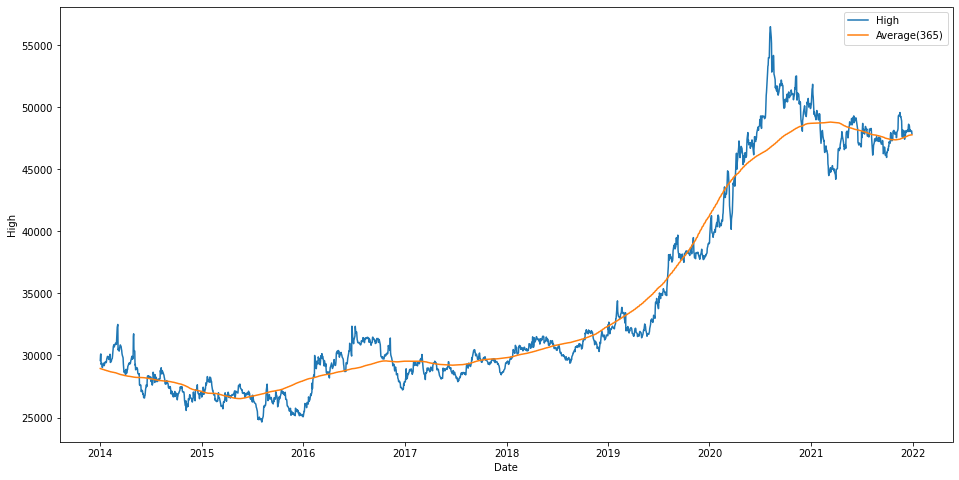

In [5]:
def trend_plot(dataset: pd.DataFrame, target: str, window_size : int, center: bool = True) -> None:
  '''
  Plots the target variable against time and plots the rolling average of 
  the target variable against time
  '''

  # get rolling average
  average = dataset.rolling(window_size, center = center, min_periods = window_size // 2).mean()[target].to_frame()
  average = average.rename(columns = {target: f'Average({window_size})'})

  # visualize the general trend in price of gold
  figure, ax = plt.subplots(1, 1, figsize = (16, 8))
  sns.lineplot(data = dataset, x = 'Date', y = target, ax = ax, label = target)
  sns.lineplot(data = average, x = 'Date', y = f'Average({window_size})', ax = ax, label = f'Average({window_size})')
  plt.show()

trend_plot(df, 'High', window_size = 365)

Based on this plot, the trend seems to be a:

1. slow increase from 2014 to 2019
2. rapid increase from 2019 to 2021.
3. stagnant from 2021 to 2022. 

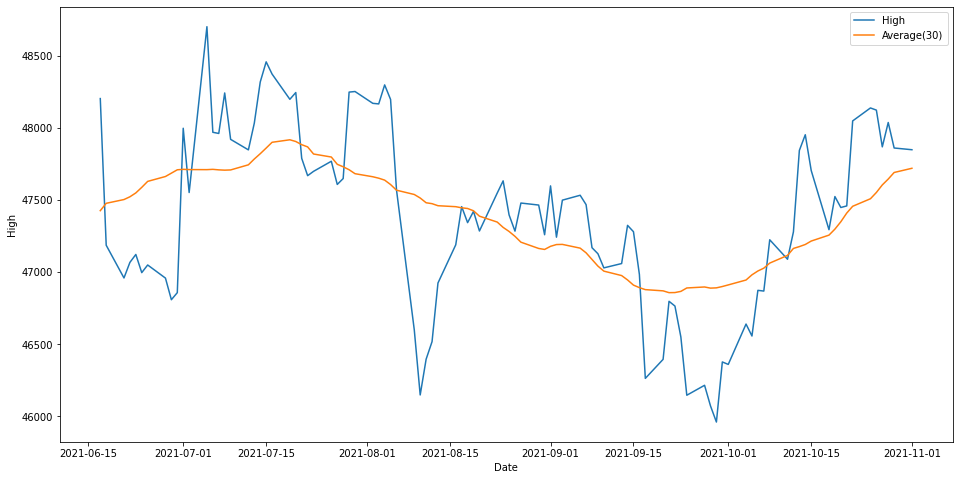

In [6]:
trend_plot(train_df, 'High', window_size = 30)

For our training period, it seems that our price of gold fluctuates about around $47k.

## Seasonality

We say that a time series exhibits seasonality whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common.

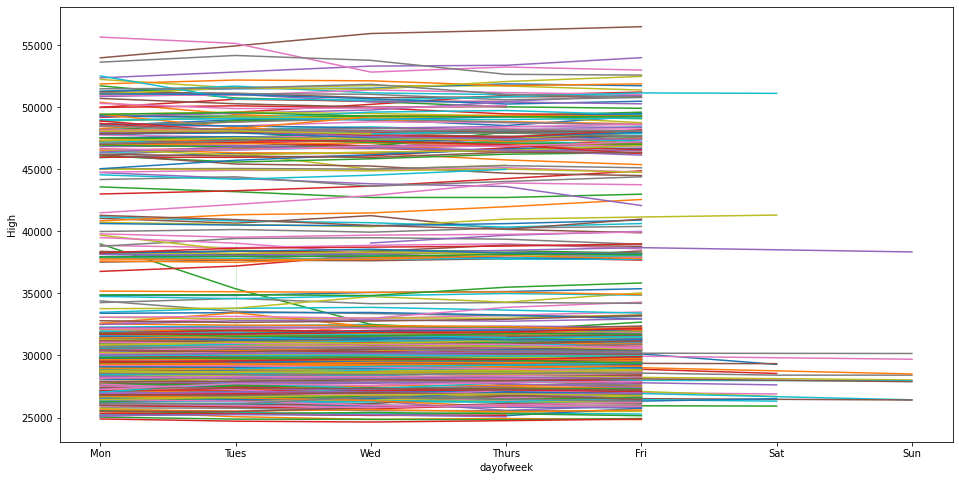

In [7]:
def seasonal_plot(dataset: pd.DataFrame, target: str) -> None:
  '''Plots the change across the price across a week'''
  
  # create information about the date
  dataset = dataset.copy()
  dataset['dayofweek'] = dataset.index.dayofweek
  dataset['week'] = pd.Int64Index(dataset.index.isocalendar().week)
  dataset['year'] = dataset.index.year

  # create figure
  figure, axes = plt.subplots(1, 1, figsize = (16, 8))
  axes.set_xticks([0, 1, 2, 3, 4, 5, 6])
  axes.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
  dataset = dataset.groupby(['year', 'week'])

  def line(dataset):
    sns.lineplot(data = dataset, x = 'dayofweek', y = target, ax = axes)
  
  dataset.apply(line)
  plt.show()

seasonal_plot(df, 'High')

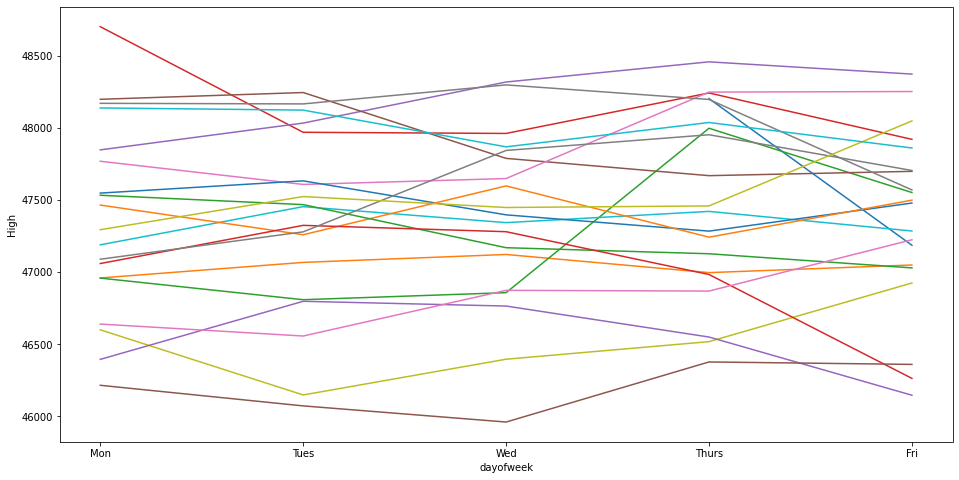

In [8]:
seasonal_plot(train_df, 'High')

Based on the 2 seasonal plots, there does not appear to be a clear trend across a week.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version


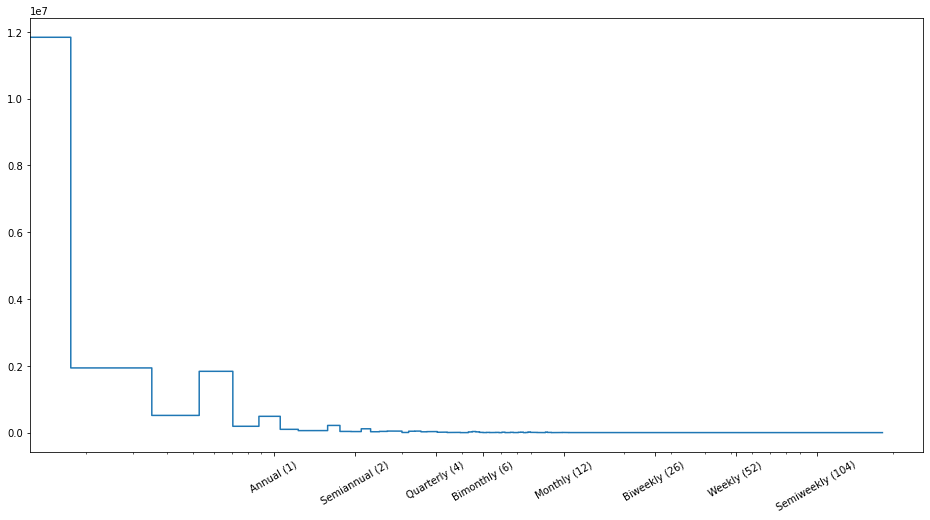

In [9]:
def periodogram_plot(dataset: pd.DataFrame, target: str, detrend: str= 'linear') -> None:
  '''Plot a periodogram'''

  # fast fourier transform
  sampling_freq = pd.Timedelta("1Y") / pd.Timedelta("1D")
  freqencies, spectrum = periodogram(
      dataset[target],
      fs = sampling_freq,
      detrend = detrend,
      scaling = 'spectrum',
  )

  # create periodogram
  figure, axes = plt.subplots(1, 1, figsize = (16, 8))
  axes.step(freqencies, spectrum)
  axes.set_xscale("log")
  axes.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
  axes.set_xticklabels(
      ["Annual (1)", "Semiannual (2)", "Quarterly (4)", "Bimonthly (6)",
       "Monthly (12)", "Biweekly (26)", "Weekly (52)", "Semiweekly (104)"],
      rotation=30,
  )
  plt.show()

periodogram_plot(df, 'High')

There appears to be some level of weak annual seasonality.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  """Entry point for launching an IPython kernel.


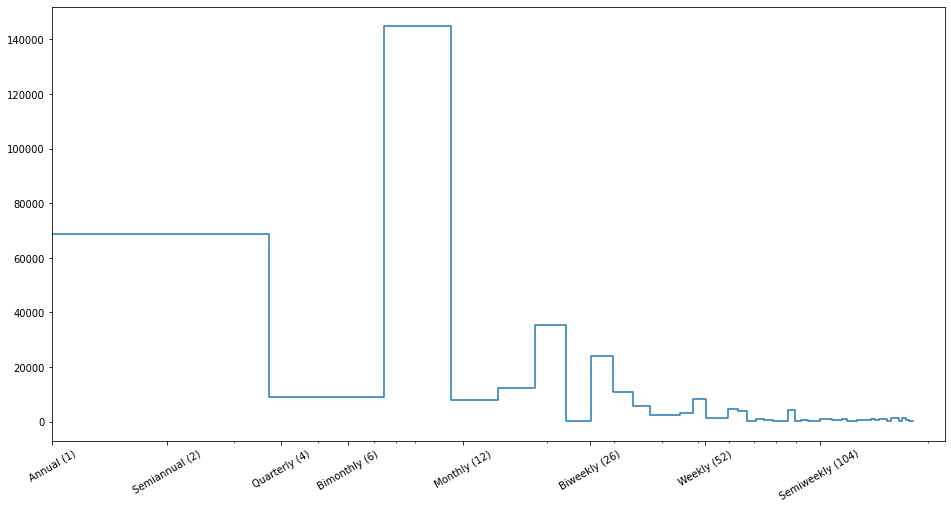

In [10]:
periodogram_plot(train_df, 'High')

In our training dataset, there appears to be annual and monthly seasonality present.

## Cyclic Fluctuations

Cycles are patterns of growth and decay in a time series associated with how the value in a series at one time depends on values at previous times, but not necessarily on the time step itself.

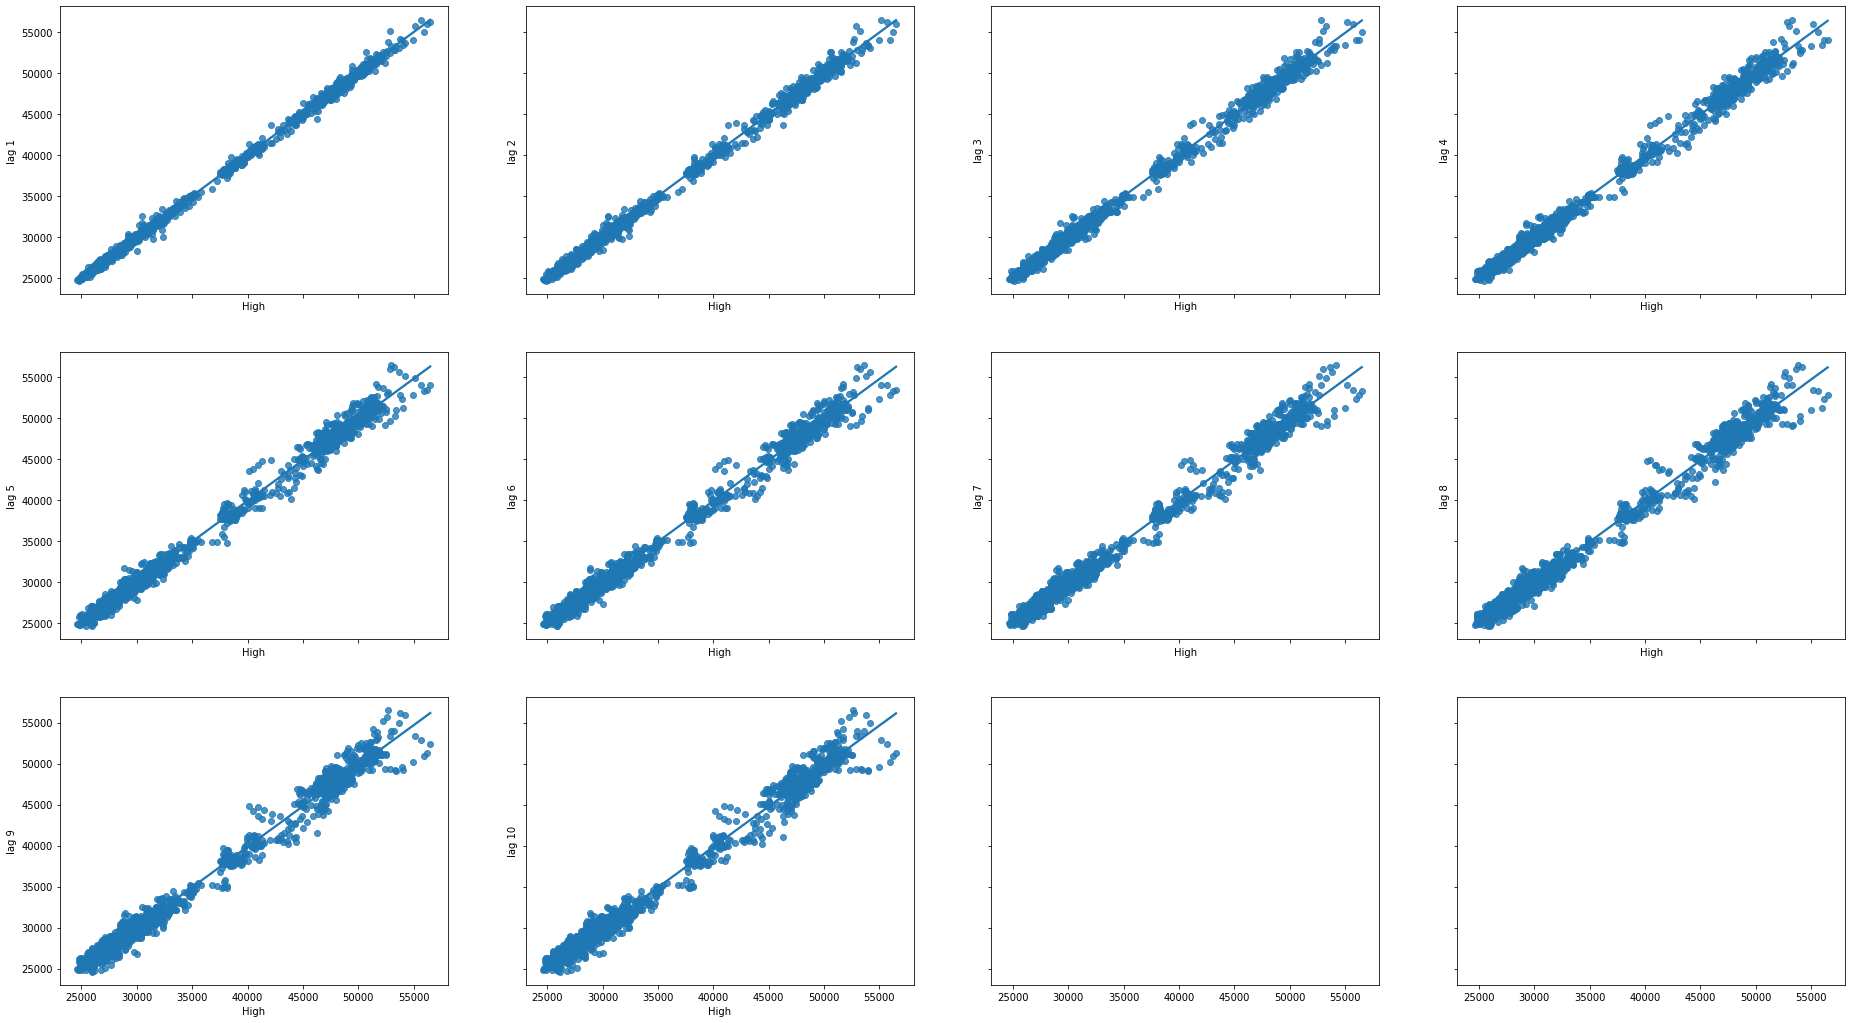

In [11]:
def lag_plot(dataset: pd.DataFrame, lags: int, x: str,  y: str = None, nrows: int = 1) -> None:
  '''Plots lag plots'''

  # setting default values
  if y is None:
    y = x

  # create lag plot
  ncols = int(np.ceil(lags / nrows))
  figure, axes = plt.subplots(nrows, ncols, figsize = (ncols * 8, nrows * 6), sharex = True, sharey = True, squeeze = False)
  for k in range(lags):
    temp = pd.DataFrame(dataset.loc[:, x])
    lag = pd.DataFrame(temp[x].shift(k + 1)).rename(columns = {x: f'lag {k + 1}'})
    temp = pd.concat([temp, lag], axis = 1).dropna()
    sns.regplot(data = temp, x = x, y = f'lag {k + 1}', ax = axes[k // ncols, k % ncols])
  plt.show()

# lag plot for full dataset
lag_plot(df, lags = 10, x = 'High', nrows = 3)

As can be seen from the lag plots, the highest price shows strong correlation with the lagged values.

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


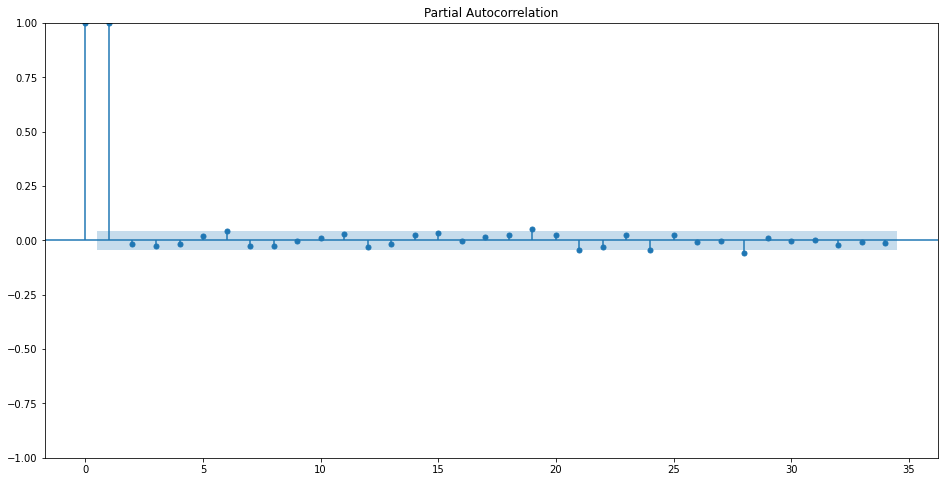

In [12]:
# partial auto correlation plot for full dataset
figure, ax = plt.subplots(1, 1, figsize = (16, 8))
_ = plot_pacf(df['High'], ax = ax)
plt.show()

Based on the partial autocorrelation plot, the only significant lag is the first lag. There are other lags which fall outside the box, however, it is likely to be a coincidence.

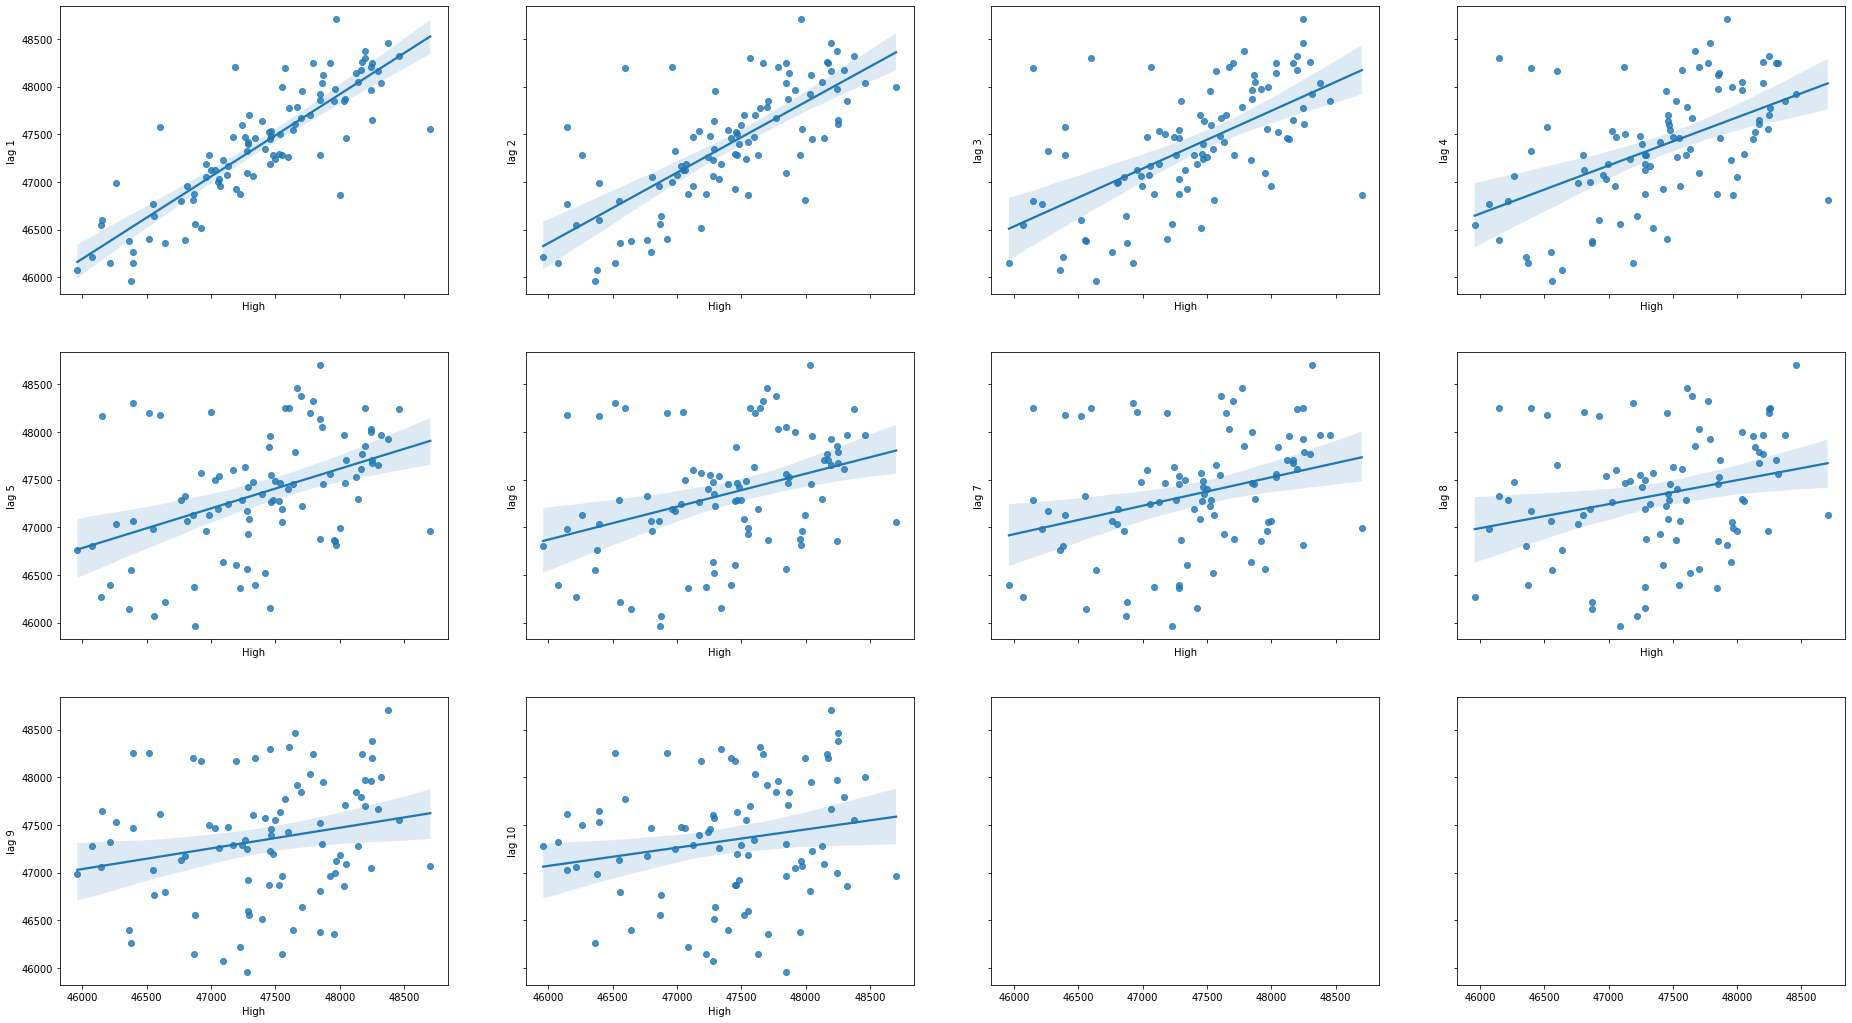

In [13]:
# lag plot for training dataset
lag_plot(train_df, lags = 10, x = 'High', nrows = 3)

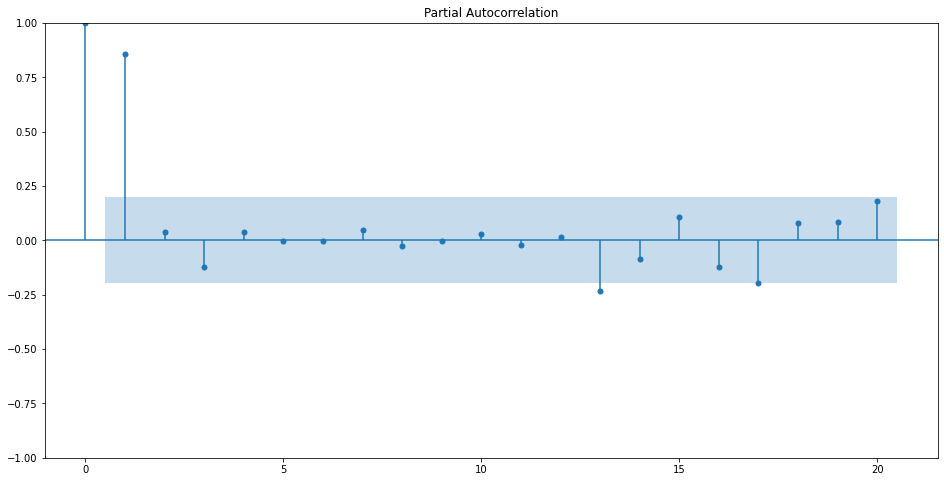

In [14]:
# partial autocorrelation plot for training dataset
figure, ax = plt.subplots(1, 1, figsize = (16, 8))
_ = plot_pacf(train_df['High'], ax = ax)
plt.show()

A similar result is obtained when applied to the training dataset.

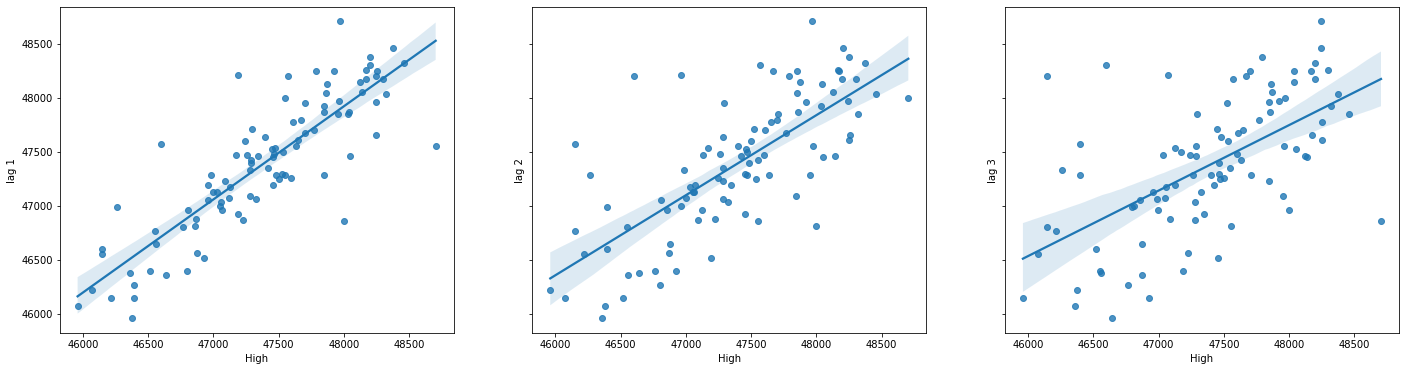

In [15]:
# lag plot of High against Price lagged
lag_plot(train_df, lags = 3, x = 'High', y = 'Price')

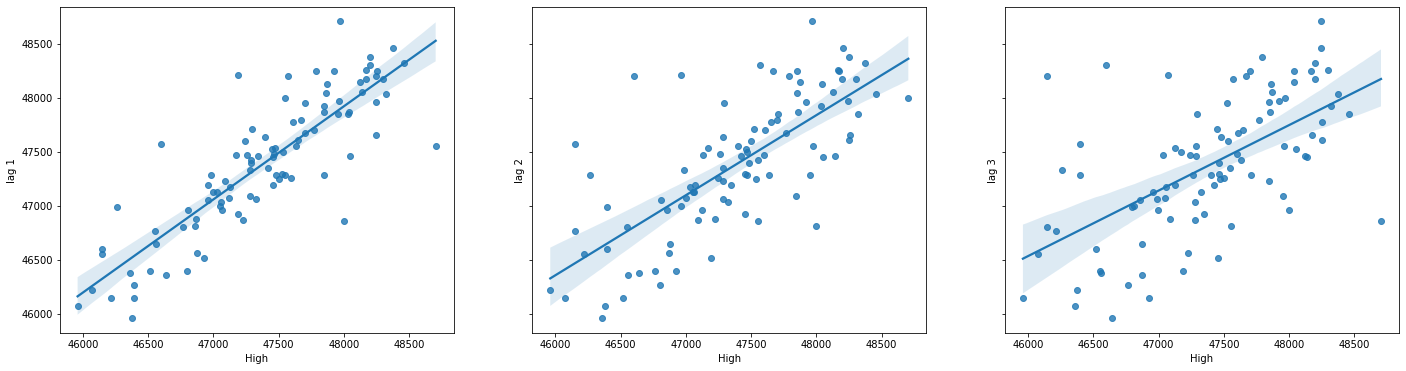

In [16]:
# lag plot of High against Low lagged
lag_plot(train_df, lags = 3, x = 'High', y = 'Low')

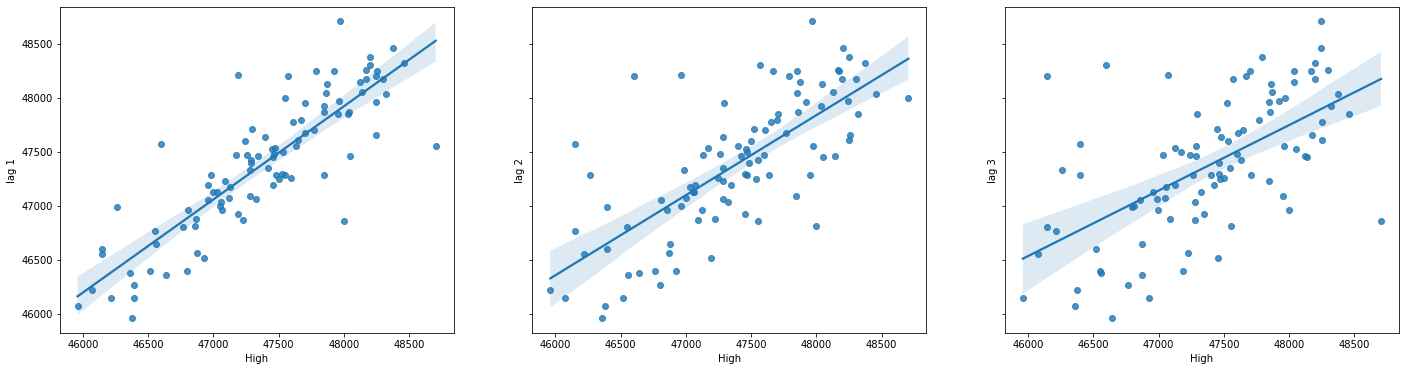

In [17]:
# lag plot of High against Volume lagged
lag_plot(train_df, lags = 3, x = 'High', y = 'Volume')

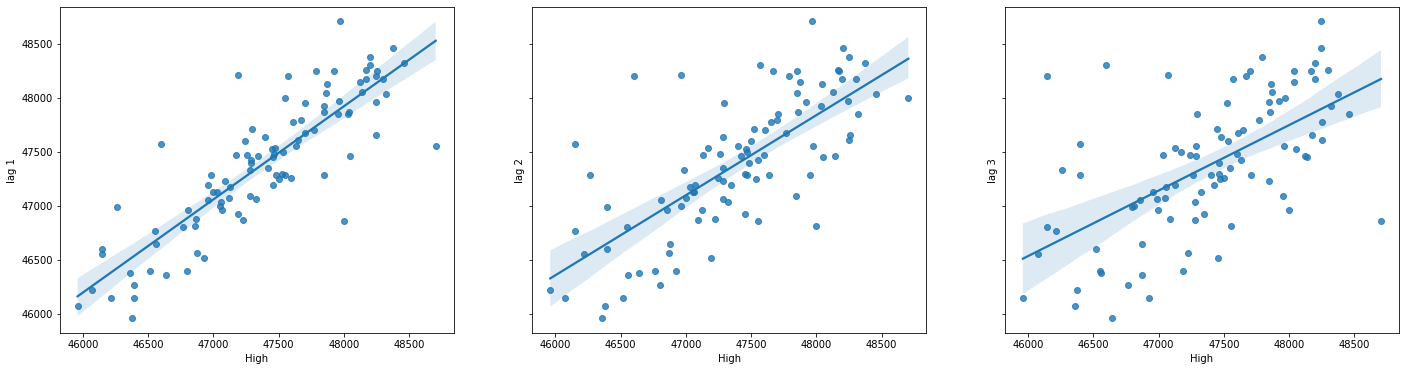

In [18]:
# lag plot of High against %chg lagged
lag_plot(train_df, lags = 3, x = 'High', y = '%chg')

There also appears to be some level of correlation between High and the lagged values of the other columns.

## Irregular Fluctuations

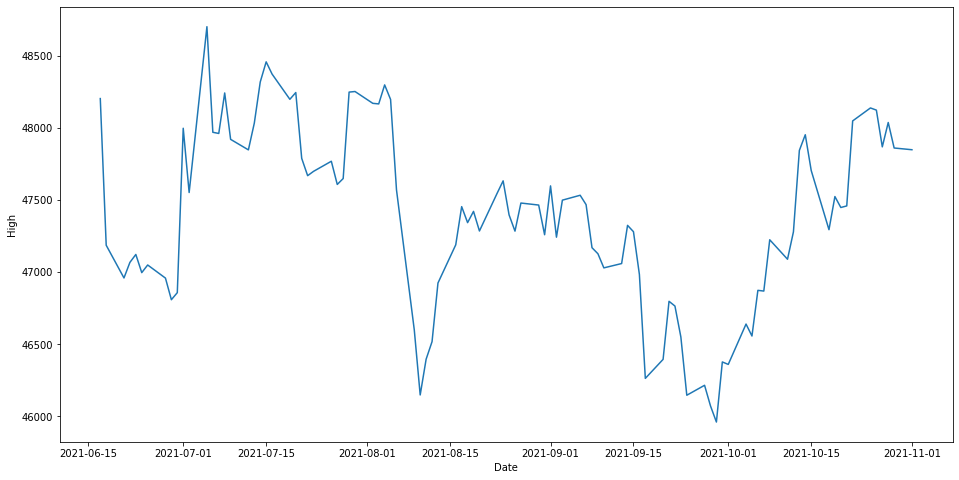

In [19]:
# visualize the fluctuations in gold high prices
figure, ax = plt.subplots(1, 1, figsize = (16, 8))
sns.lineplot(data = train_df, x = 'Date', y = 'High', ax = ax)
plt.show()

There does not appear to be any irregular fluctuations in the training dataset.

# Modelling and Evaluation

---

## Data Preparation

In [20]:
# creating datasets accounting for lag
train_start = pd.Timestamp(year = 2021, month = 6, day = 16)
train_end = pd.Timestamp(year = 2021, month = 11, day = 1)
validate_start = pd.Timestamp(year = 2021, month = 11, day = 1)
validate_end = pd.Timestamp(year = 2021, month = 12, day = 9)
test_start = pd.Timestamp(year = 2021, month = 12, day = 9)
test_end = pd.Timestamp(year = 2021, month = 12, day = 29)

train_df = date_split(df, train_start, train_end)
validate_df = date_split(df, validate_start, validate_end)
test_df = date_split(df, test_start, test_end)

print(f"""\
Size of train data:\t {train_df.shape[0]}
Size of validate data:\t {validate_df.shape[0]}
Size of test data:\t {test_df.shape[0]}
""")

Size of train data:	 99
Size of validate data:	 29
Size of test data:	 15



In [21]:
def make_X1(dataset:pd.DataFrame) -> pd.DataFrame:
  fourier = CalendarFourier(freq = "A", order = 1)

  dp = DeterministicProcess(
    index = dataset.index, 
    order = 1,  
    additional_terms = [fourier], 
    drop = True
  )

  X_1 = dp.in_sample()

  return X_1

def make_X2(dataset: pd.DataFrame) -> pd.DataFrame:
  X_2 = pd.DataFrame(index = dataset.index)
  X_2['Price_lag1'] = dataset['Price'].shift(1)
  X_2['High_lag1'] = dataset['High'].shift(1)
  X_2['Low_lag1'] = dataset['Low'].shift(1)
  X_2['Volume_lag1'] = dataset['Volume'].shift(1)
  X_2['Chg%_lag1'] = dataset['Chg%'].shift(1)
  X_2['Open'] = dataset['Open']
  X_2 = X_2.dropna()
  
  return X_2

def make_X(dataset: pd.DataFrame) -> pd.DataFrame:
  X_1 = make_X1(dataset)
  X_2 = make_X2(dataset)
  X_1 = pd.DataFrame(X_1.loc[X_2.index, :])
  return X_1, X_2

def make_Y(dataset: pd.DataFrame, indices) -> pd.DataFrame:
  y = pd.DataFrame(dataset.loc[:, 'High'])
  y = y.loc[indices]
  return y

In [22]:
# create predictors and labels
train_x1, train_x2 = make_X(train_df)
train_y = make_Y(train_df, train_x2.index)
validate_x1, validate_x2 = make_X(validate_df)
validate_y = make_Y(validate_df, validate_x2.index)
test_x1, test_x2 = make_X(test_df)
test_y = make_Y(test_df, test_x2.index)

## Hybrid Model

In [23]:
class HybridModel:
  def __init__(self, model_1, model_2):
    self.model_1 = model_1
    self.model_2 = model_2
    self.y_columns = None

  def fit(self, X_1, X_2, y):
    self.model_1.fit(X_1, y)
    y_pred = pd.DataFrame(self.model_1.predict(X_1), index = X_1.index, columns = y.columns) 
    y_diff = y - y_pred
    y_diff = y_diff.stack().squeeze() 
    self.model_2.fit(X_2, y_diff)
    self.y_columns = y.columns

  def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(self.model_1.predict(X_1), index = X_1.index, columns = self.y_columns).stack().squeeze()
    y_pred += self.model_2.predict(X_2)
    return y_pred.unstack()

Train RMSE: 86.72741227459073


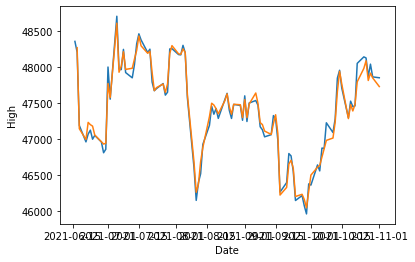

In [24]:
# create model
model = HybridModel(ElasticNet(), RandomForestRegressor())
model.fit(train_x1, train_x2, train_y)

# model predictions
predictions = pd.DataFrame(model.predict(train_x1, train_x2), index = train_x1.index)
predictions = predictions.rename(columns = {'High' : 'High Prediction'})

# performance evaluation
RMSE = mean_squared_error(train_y['High'], predictions['High Prediction']) ** 0.5
print(f"Train RMSE: {RMSE}")
sns.lineplot(data = train_df, x = 'Date', y = 'High')
sns.lineplot(data = predictions, x = 'Date', y = 'High Prediction')
plt.show()

Validate RMSE: 639.5499706965818


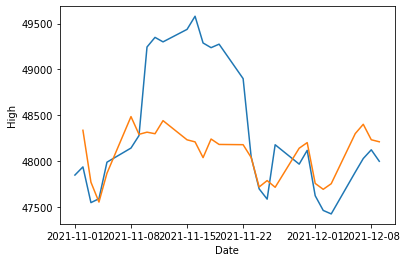

In [25]:
# model predictions
predictions = pd.DataFrame(model.predict(validate_x1, validate_x2), index = validate_x1.index)
predictions = predictions.rename(columns = {'High' : 'High Prediction'})

# performance evaluation
RMSE = mean_squared_error(validate_y['High'], predictions['High Prediction']) ** 0.5
print(f"Validate RMSE: {RMSE}")
sns.lineplot(data = validate_df, x = 'Date', y = 'High')
sns.lineplot(data = predictions, x = 'Date', y = 'High Prediction')
plt.show()

Test RMSE: 238.15064430914163


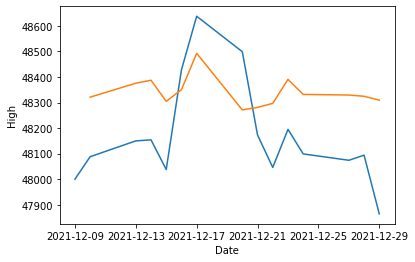

In [26]:
# model predictions
predictions = pd.DataFrame(model.predict(test_x1, test_x2), index = test_x1.index)
predictions = predictions.rename(columns = {'High' : 'High Prediction'})

# performance evaluation
RMSE = mean_squared_error(test_y['High'], predictions['High Prediction']) ** 0.5
print(f"Test RMSE: {RMSE}")
sns.lineplot(data = test_df, x = 'Date', y = 'High')
sns.lineplot(data = predictions, x = 'Date', y = 'High Prediction')
plt.show()

## Evaluation

In [27]:
# naive method
residuals = test_df['High'] - test_df['High'].shift(1)
std = residuals.dropna().std()

# confidence testing
if std * 1.96 >= mean_absolute_error(test_y['High'], predictions['High Prediction']):
  print("Model prediction is within 95% confidence")
else:
  print("Model prediction is not within 95% confidence")

Model prediction is within 95% confidence
